In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# define training and test data directories
train_dir = '/content/drive/MyDrive/Colab Notebooks/group_2/train'
test_dir ='/content/drive/MyDrive/Colab Notebooks/group_2/valid'
test_dir1 ='/content/drive/MyDrive/Colab Notebooks/group_2/test'

# classes are folders in each directory with these games
classes = ['archery','barell racing','bike polo','bowling','canoe slamon','croquet','field hockey','fly fishing','gaga','horse jumping','hang gliding','hydroplane racing','javelin','log rolling','nascar racing','pole dancing','rings','rowing','shuffleboard','skydiving','steer wrestling','table tennis','tug of war','water cycling','wheelchair']

In [5]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
valid_data = datasets.ImageFolder(test_dir1, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))
print('Num valid images: ', len(valid_data))

Num training images:  3331
Num test images:  125
Num valid images:  125


In [6]:
batch_size =32
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

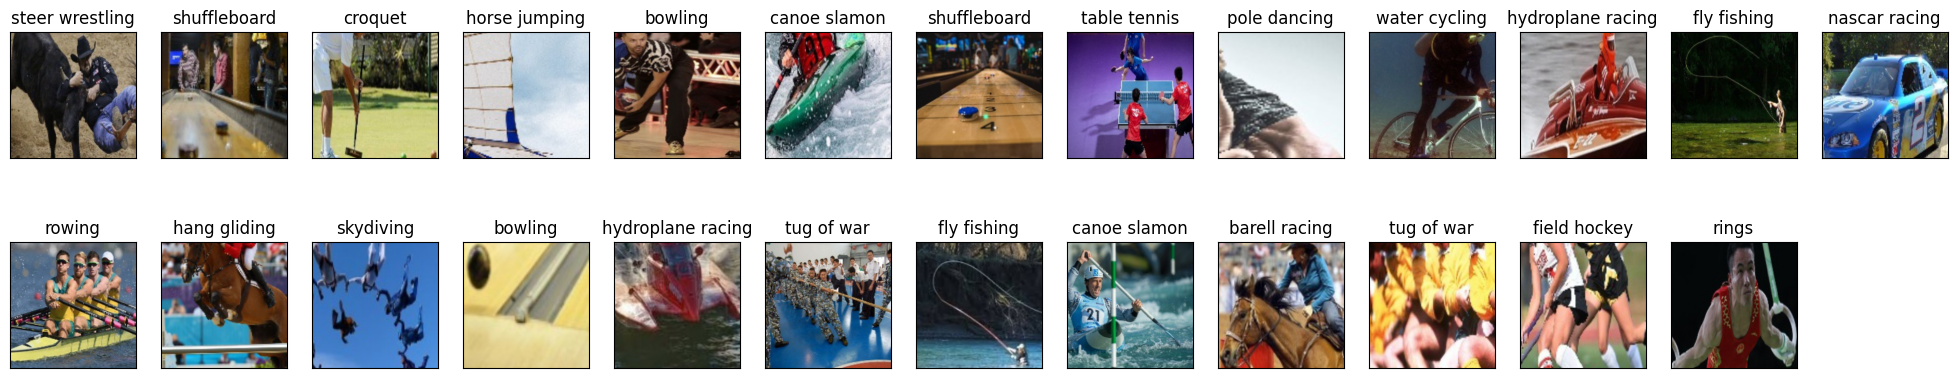

In [7]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()
fig = plt.figure(figsize=(25, 5))
for idx in np.arange(25):
    ax = fig.add_subplot(2, 13, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


In [8]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 281MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 


4096
1000


In [10]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    

In [11]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 25 sports classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

25


In [12]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
import torch.optim as optim

# Set the weight decay parameter
weight_decay = 0.001
criterion = nn.CrossEntropyLoss()
# Define the optimizer with weight decay
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)

In [25]:
n_epochs = 30
losses=np.zeros(30)
print('batch_size :',batch_size)

# Set device variable to "cuda" if CUDA is available, else set it to "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    x=0

    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # Move data to GPU if available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = vgg16(data)

        # Compute the loss with L2 regularization
        l2_reg = torch.tensor(0., device=device)
        for param in vgg16.parameters():
            l2_reg += torch.norm(param.to(device))
        loss = criterion(output, target) + weight_decay * l2_reg

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss
        train_loss = train_loss + loss.item()
        
        if batch_i % 25 == 24:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 25))
            x+=train_loss / 25
            train_loss = 0.0
    losses[epoch-1] =x

batch_size : 32
Epoch 1, Batch 25 loss: 1.1106323337554931
Epoch 1, Batch 50 loss: 1.1471008205413817
Epoch 1, Batch 75 loss: 1.0690245151519775
Epoch 1, Batch 100 loss: 1.1284694123268126
Epoch 2, Batch 25 loss: 1.0978894591331483
Epoch 2, Batch 50 loss: 1.0471177935600280
Epoch 2, Batch 75 loss: 1.0179802274703980
Epoch 2, Batch 100 loss: 1.1073051047325135
Epoch 3, Batch 25 loss: 0.9929022550582886
Epoch 3, Batch 50 loss: 0.9837042951583862
Epoch 3, Batch 75 loss: 1.0303396701812744
Epoch 3, Batch 100 loss: 1.0071853184700013
Epoch 4, Batch 25 loss: 1.0324562120437621
Epoch 4, Batch 50 loss: 0.9628141450881958
Epoch 4, Batch 75 loss: 0.9609650206565857
Epoch 4, Batch 100 loss: 0.9206944990158081
Epoch 5, Batch 25 loss: 0.9360395598411561
Epoch 5, Batch 50 loss: 0.9113729619979858
Epoch 5, Batch 75 loss: 0.9314677262306214
Epoch 5, Batch 100 loss: 0.8744842720031738
Epoch 6, Batch 25 loss: 0.9419975566864014
Epoch 6, Batch 50 loss: 0.8551929473876954
Epoch 6, Batch 75 loss: 0.9411534

In [32]:
n_epochs = 30
losses=np.zeros(30)
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    x=0
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 25 == 24:    # print training loss every specified number of mini-batches size =25
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 25))
            x+=train_loss / 25
            train_loss = 0.0
    losses[epoch-1] =x

Epoch 1, Batch 25 loss: 0.2255421037226915
Epoch 1, Batch 50 loss: 0.2123978039622307
Epoch 1, Batch 75 loss: 0.2350790262222290
Epoch 1, Batch 100 loss: 0.2240418036282062
Epoch 2, Batch 25 loss: 0.2290674896538258
Epoch 2, Batch 50 loss: 0.2616358062624931
Epoch 2, Batch 75 loss: 0.2511676114797592
Epoch 2, Batch 100 loss: 0.1984388435631990
Epoch 3, Batch 25 loss: 0.2439902390539646
Epoch 3, Batch 50 loss: 0.2028665736317635
Epoch 3, Batch 75 loss: 0.2134167778491974
Epoch 3, Batch 100 loss: 0.2083361259102821
Epoch 4, Batch 25 loss: 0.2328636192530394
Epoch 4, Batch 50 loss: 0.2524826174974442
Epoch 4, Batch 75 loss: 0.2176166294515133
Epoch 4, Batch 100 loss: 0.2084988409280777
Epoch 5, Batch 25 loss: 0.2251310074329376
Epoch 5, Batch 50 loss: 0.2266616085171700
Epoch 5, Batch 75 loss: 0.2482716464996338
Epoch 5, Batch 100 loss: 0.2367190366983414
Epoch 6, Batch 25 loss: 0.2355674006044865
Epoch 6, Batch 50 loss: 0.2139612963795662
Epoch 6, Batch 75 loss: 0.2067028220742941
Epoch 

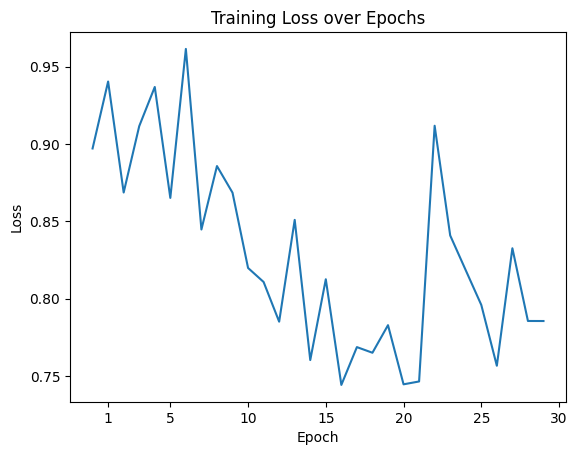

In [34]:
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([1,5,10,15,20,25,30])
plt.show()


In [38]:
test_loss = 0.0
class_correct = list(0. for i in range(25))
class_total = list(0. for i in range(25))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(data.size(0)):
        if i >= len(target):
            break
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(25):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.220184

Test Accuracy of archery: 80% ( 4/ 5)
Test Accuracy of barell racing: 100% ( 5/ 5)
Test Accuracy of bike polo: 80% ( 4/ 5)
Test Accuracy of bowling: 80% ( 4/ 5)
Test Accuracy of canoe slamon: 80% ( 4/ 5)
Test Accuracy of croquet: 100% ( 5/ 5)
Test Accuracy of field hockey: 100% ( 5/ 5)
Test Accuracy of fly fishing: 60% ( 3/ 5)
Test Accuracy of  gaga: 100% ( 5/ 5)
Test Accuracy of horse jumping: 100% ( 5/ 5)
Test Accuracy of hang gliding: 100% ( 5/ 5)
Test Accuracy of hydroplane racing: 100% ( 5/ 5)
Test Accuracy of javelin: 100% ( 5/ 5)
Test Accuracy of log rolling: 80% ( 4/ 5)
Test Accuracy of nascar racing: 100% ( 5/ 5)
Test Accuracy of pole dancing: 100% ( 5/ 5)
Test Accuracy of rings: 100% ( 5/ 5)
Test Accuracy of rowing: 80% ( 4/ 5)
Test Accuracy of shuffleboard: 100% ( 5/ 5)
Test Accuracy of skydiving: 100% ( 5/ 5)
Test Accuracy of steer wrestling: 80% ( 4/ 5)
Test Accuracy of table tennis: 100% ( 5/ 5)
Test Accuracy of tug of war: 100% ( 5/ 5)
Test Accuracy 

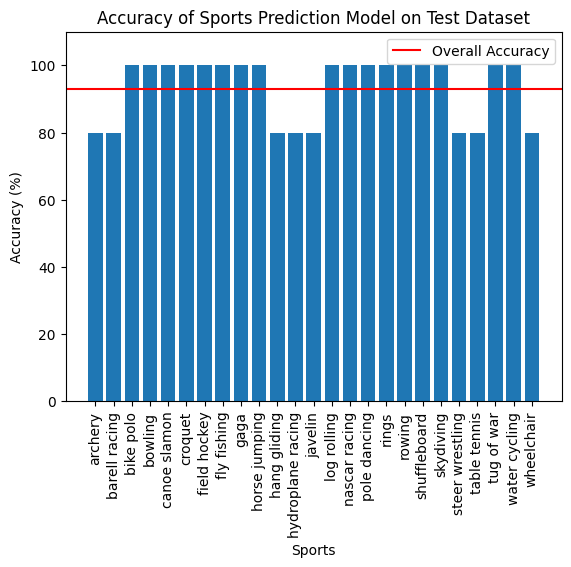

In [28]:
import matplotlib.pyplot as plt

activities = ['archery', 'barell racing', 'bike polo', 'bowling', 'canoe slamon', 'croquet', 'field hockey', 'fly fishing', 'gaga', 'horse jumping', 'hang gliding', 'hydroplane racing', 'javelin', 'log rolling', 'nascar racing', 'pole dancing', 'rings', 'rowing', 'shuffleboard', 'skydiving', 'steer wrestling', 'table tennis', 'tug of war', 'water cycling', 'wheelchair']
accuracies = [80, 80, 100, 100, 100, 100, 100, 100, 100, 100, 80, 80, 80, 100, 100, 100, 100, 100, 100, 100, 80, 80, 100, 100, 80]
overall_accuracy = 93

plt.bar(activities, accuracies)
plt.axhline(y=overall_accuracy, color='r', linestyle='-', label='Overall Accuracy')
plt.xticks(rotation=90)
plt.ylim([0, 110])
plt.xlabel('Sports')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Sports Prediction Model on Test Dataset')
plt.legend()
plt.show()


In [29]:
valid_loss = 0.0
class_correct = list(0. for i in range(25))
class_total = list(0. for i in range(25))

vgg16.eval() # eval mode

# iterate over test data
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(data.size(0)):
        if i >= len(target):
            break
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
valid_loss = valid_loss/len(valid_loader.dataset)
print('Valid Loss: {:.6f}\n'.format(valid_loss))

for i in range(25):
    if class_total[i] > 0:
        print('Valid Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Valid Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nValid Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Valid Loss: 0.155665

Valid Accuracy of archery: 100% ( 5/ 5)
Valid Accuracy of barell racing: 80% ( 4/ 5)
Valid Accuracy of bike polo: 100% ( 5/ 5)
Valid Accuracy of bowling: 100% ( 5/ 5)
Valid Accuracy of canoe slamon: 100% ( 5/ 5)
Valid Accuracy of croquet: 100% ( 5/ 5)
Valid Accuracy of field hockey: 100% ( 5/ 5)
Valid Accuracy of fly fishing: 100% ( 5/ 5)
Valid Accuracy of  gaga: 100% ( 5/ 5)
Valid Accuracy of horse jumping: 100% ( 5/ 5)
Valid Accuracy of hang gliding: 80% ( 4/ 5)
Valid Accuracy of hydroplane racing: 60% ( 3/ 5)
Valid Accuracy of javelin: 100% ( 5/ 5)
Valid Accuracy of log rolling: 100% ( 5/ 5)
Valid Accuracy of nascar racing: 100% ( 5/ 5)
Valid Accuracy of pole dancing: 100% ( 5/ 5)
Valid Accuracy of rings: 100% ( 5/ 5)
Valid Accuracy of rowing: 80% ( 4/ 5)
Valid Accuracy of shuffleboard: 100% ( 5/ 5)
Valid Accuracy of skydiving: 100% ( 5/ 5)
Valid Accuracy of steer wrestling: 100% ( 5/ 5)
Valid Accuracy of table tennis: 100% ( 5/ 5)
Valid Accuracy of tug of war:

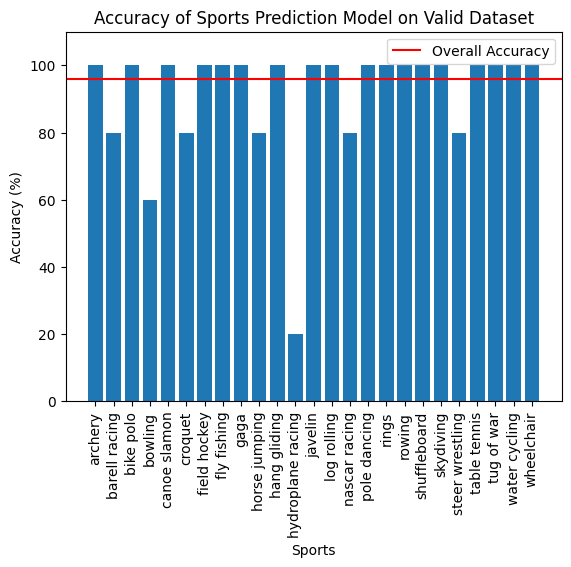

In [33]:
import matplotlib.pyplot as plt

activities = ['archery', 'barell racing', 'bike polo', 'bowling', 'canoe slamon', 'croquet', 'field hockey', 'fly fishing', 'gaga', 'horse jumping', 'hang gliding', 'hydroplane racing', 'javelin', 'log rolling', 'nascar racing', 'pole dancing', 'rings', 'rowing', 'shuffleboard', 'skydiving', 'steer wrestling', 'table tennis', 'tug of war', 'water cycling', 'wheelchair']
accuracies = [100, 80, 100, 100, 100, 80, 100, 100, 100, 80, 100, 80, 100, 100, 80, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
overall_accuracy = 96

plt.bar(activities, accuracies)
plt.axhline(y=overall_accuracy, color='r', linestyle='-', label='Overall Accuracy')
plt.xticks(rotation=90)
plt.ylim([0, 110])
plt.xlabel('Sports')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Sports Prediction Model on Valid Dataset')
plt.legend()
plt.show()


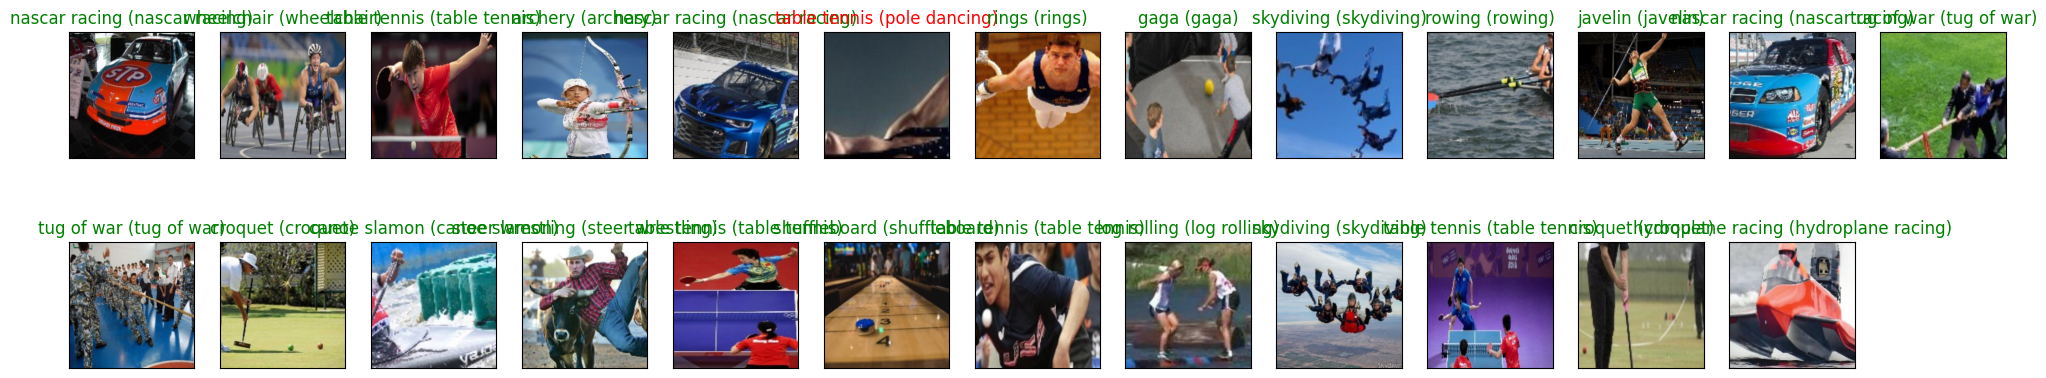

In [39]:
 # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.cpu().numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = torch.from_numpy(images).cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 5))
for idx in np.arange(25):
    ax = fig.add_subplot(2, 13, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].cpu().numpy().transpose((1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
